# Coverage of EP full-text dataset

## Table of contents:
    
* [Introduction](#Introduction)
* [1. Load data](#1.-Load-data)
* [2. Data processing](#2.-Data-processing)
* [3. Assess data coverage](#3.-Assess-data-coverage)

## Introduction

- Coverage according to the EP: https://www.epo.org/searching-for-patents/technical/full-text-additions.html

* [ ] The problem may come from the dataset containing the full text data!
* [ ] Plot an estimation of the availability of the claims of European patents according to the number of citations 

In [366]:
import pandas as pd
import warnings

In [367]:
# show all columns in pandas
pd.set_option('display.max_columns', 500)
# disable warnings
warnings.filterwarnings("ignore")

In [368]:
# location of the PATSTAT data previously retrieved with the data_extraction_from_PATSTAT.ipynb notebook
output_files_prefix = "wind_tech_1990_2020_with_publications"
pre = '../data/raw/' + output_files_prefix
suf = '.csv'

## 1. Load data

In [369]:
# for convenience, we store all the data retrieved into a single data object.
data = {'_table_main_patent_infos': pd.read_csv(pre + '_table_main_patent_infos' + suf, low_memory=False),
       '_table_cpc': pd.read_csv(pre + '_table_cpc' + suf, low_memory=False), 
       '_table_patentees_info': pd.read_csv(pre + '_table_patentees_info' + suf, low_memory=False),
       '_table_backward_docdb_citations': pd.read_csv(pre + '_table_backward_docdb_citations' + suf, low_memory=False),
       '_table_forward_docdb_citations': pd.read_csv(pre + '_table_forward_docdb_citations' + suf, low_memory=False),
       '_text_data':pd.read_csv('../data/raw/wind_tech_1990_2020_with_publications_full_text.csv', sep = ',')}

In [370]:
data['_table_main_patent_infos']

,index,appln_id,appln_id.1,appln_auth,appln_nr,appln_kind,appln_filing_date,appln_filing_year,appln_nr_epodoc,appln_nr_original,ipr_type,receiving_office,internat_appln_id,int_phase,reg_phase,nat_phase,earliest_filing_date,earliest_filing_year,earliest_filing_id,earliest_publn_date,earliest_publn_year,earliest_pat_publn_id,granted,docdb_family_id,inpadoc_family_id,docdb_family_size,nb_citing_docdb_fam,nb_applicants,nb_inventors,appln_id.2,appln_title_lg,appln_title,appln_id.3,appln_abstract_lg,appln_abstract,appln_id.4,ipc_class_symbol,ipc_class_level,ipc_version,ipc_value,ipc_position,ipc_gener_auth,appln_id.5,nace2_code,weight,pat_publn_id,publn_auth,publn_nr,publn_nr_original,publn_kind,appln_id.6,publn_date,publn_lg,publn_first_grant,publn_claims
0,0,146,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,PI,,0,N,Y,N,2006-08-21,2006,15047229,2008-02-27,2008,278556884,1,38752541,137,5,6,1,3,146.0,en,Method for operating wind farms,146.0,en,The method involves defining an idle power int...,146.0,H02J 3/18,A,2006-01-01,I,L,EP,146.0,27.12,0.333333,278556884,EP,1892412,NaN,A1,146,2008-02-27,de,0,7
1,0,146,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,PI,,0,N,Y,N,2006-08-21,2006,15047229,2008-02-27,2008,278556884,1,38752541,137,5,6,1,3,146.0,en,Method for operating wind farms,146.0,en,The method involves defining an idle power int...,146.0,F03D 9/00,A,2006-01-01,I,L,EP,146.0,27.12,0.333333,278556884,EP,1892412,NaN,A1,146,2008-02-27,de,0,7
2,0,146,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,PI,,0,N,Y,N,2006-08-21,2006,15047229,2008-02-27,2008,278556884,1,38752541,137,5,6,1,3,146.0,en,Method for operating wind farms,146.0,en,The method involves defining an idle power int...,146.0,F03D 7/04,A,2006-01-01,I,F,EP,146.0,27.12,0.333333,278556884,EP,1892412,NaN,A1,146,2008-02-27,de,0,7
3,0,146,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,PI,,0,N,Y,N,2006-08-21,2006,15047229,2008-02-27,2008,278556884,1,38752541,137,5,6,1,3,146.0,en,Method for operating wind farms,146.0,en,The method involves defining an idle power int...,146.0,H02J 3/18,A,2006-01-01,I,L,EP,146.0,28.10,0.666667,335943971,EP,1892412,NaN,B1,146,2011-07-27,de,1,6
4,0,146,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,PI,,0,N,Y,N,2006-08-21,2006,15047229,2008-02-27,2008,278556884,1,38752541,137,5,6,1,3,146.0,en,Method for operating wind farms,146.0,en,The method involves defining an idle power int...,146.0,F03D 9/00,A,2006-01-01,I,L,EP,146.0,28.10,0.666667,335943971,EP,1892412,NaN,B1,146,2011-07-27,de,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715880,106270,489220752,489220752,TW,105143792,A,2016-12-29,2016,TW20160143792,105143792,PI,,0,N,N,Y,2015-12-30,2015,481022695,2017-10-16,2017,489220753,0,59225958,10781171,3,0,1,5,489220752.0,en,Electro-mechanical bridles for energy kites,489220752.0,en,An energy kite may be coupled to a tether and ...,489220752.0,D07B 1/02,A,2006-01-01,I,L,TW,489220752.0,28.10,0.600000,489220753,TW,201736722,201736722,A,489220752,2017-10-16,zh,0,0
715881,106270,489220752,489220752,TW,105143792,A,2016-12-29,2016,TW20160143792,105143792,PI,,0,N,N,Y,2015-12-30,2015,481022695,2017-10-16,2017,489220753,0,59225958,10781171,3,0,1,5,489220752.0,en,Electro-mechanical bridles for energy kites,489220752.0,en,An energy kite may be coupled to a tether and ...,489220752.0,F03D 5/06,A,2006-01-01,I,L,TW,489220752.0,28.10,0.600000,489220753,TW,201736722,201736722,A,489220752,2017-10-16,zh,0,0
715882,106270,489220752,489220752,TW,105143792,A,2016-12-29,2016,TW20160143792,105143792,PI,,0,N,N,Y,2015-12-30,2015,481022695,2017-10-16,2017,489220753,0,59225958,10781171,3,0,1,5,489220752.0,en,Electro-mechanical bridles for energy kites,489220752.0,en,An energy kite may be coupled to a tether and ...,489220752.0,F03D 5/00,A,2006-01-01,I,F,TW,4892

## 2. Data processing

In [371]:
def reshape_PATSTAT_data(data):
    """ Reshaping PATSTAT data """
    
    # retrieve variables of interest from the PATSTAT dataset
    cols = ['appln_id','appln_filing_year','appln_auth','publn_auth',
            'publn_nr','publn_nr_original','publn_lg']
    table_PATSTAT = data['_table_main_patent_infos'][cols]

    # drop duplicates
    table_PATSTAT.drop_duplicates(inplace = True)
    # we place old and new publication numbers in the same columns (wide to long reshape)
    table_PATSTAT = pd.melt(table_PATSTAT,
                            id_vars=['appln_id', 'appln_filing_year','appln_auth', 'publn_auth',
                                     'publn_lg'],
                            var_name='type_publication_nb',
                            value_name='publn_nr')
    return table_PATSTAT

In [372]:
def reshape_EP_full_text_data(data):
    """ Reshapes the EP full text data to be able to assess the wether a PATSTAT patent is present
    in the database """
    
    # retrieve variables of interest from the EP full text data
    table_EP_full_text = data['_text_data']
    # renaming the publication number column to align with PATSTAT before merging
    table_EP_full_text.rename(columns={'publication_number':  'publn_nr'}, inplace = True)
    # keep only patent which contains claims
    condition = table_EP_full_text['text_type'] == 'CLAIM'
    table_EP_full_text = table_EP_full_text[condition]
    # drop duplicates and keep only 2 variables
    table_EP_full_text = table_EP_full_text[['publn_nr', 'text_type']]
    table_EP_full_text.drop_duplicates(inplace = True)
    # store the ids as str
    table_EP_full_text['publn_nr'] = table_EP_full_text['publn_nr'].astype(str)
    return table_EP_full_text

In [373]:
def add_citations(data, table_PATSTAT):
    
    df = data['_table_main_patent_infos']
    mapp = dict(zip(df['appln_id'],df['nb_citing_docdb_fam']))
    table_PATSTAT['nb_citing_docdb_fam'] = table_PATSTAT['appln_id'].map(mapp)
    return table_PATSTAT

In [374]:
table_PATSTAT = reshape_PATSTAT_data(data)
table_PATSTAT = add_citations(data, table_PATSTAT)
table_PATSTAT.head()

,appln_id,appln_filing_year,appln_auth,publn_auth,publn_lg,type_publication_nb,publn_nr,nb_citing_docdb_fam
0,146,2007,EP,EP,de,publn_nr,1892412,6
1,1040,2007,EP,EP,de,publn_nr,1944506,7
2,1042,2002,EP,EP,de,publn_nr,1944509,51
3,2176,2006,EP,EP,en,publn_nr,1937967,43
4,2176,2006,EP,EP,en,publn_nr,1937967,43


In [375]:
table_EP_full_text = reshape_EP_full_text_data(data)
table_EP_full_text.head()

,publn_nr,text_type
5,92,CLAIM
12,415,CLAIM
19,872,CLAIM
26,1611,CLAIM
33,1874,CLAIM


## 3. Assess data coverage

In [382]:
# merging the two datasets 
mapp = dict(zip(table_EP_full_text['publn_nr'],table_EP_full_text['text_type']))
table_PATSTAT['claims_availability'] = table_PATSTAT['publn_nr'].map(mapp).fillna('No')
mapp = {}
mapp['CLAIM'] = 'Yes'
table_PATSTAT['claims_availability'] = table_PATSTAT['claims_availability'].map(mapp).fillna(table_PATSTAT['claims_availability'])
# if we have a claim, we drop duplicates for the other (unmatched) publication numbers
table_PATSTAT.sort_values(by = 'claims_availability', ascending = False, inplace = True)
table_PATSTAT.drop_duplicates(subset = 'appln_id', inplace = True)

In [383]:
table_PATSTAT.head()

,appln_id,appln_filing_year,appln_auth,publn_auth,publn_lg,type_publication_nb,publn_nr,nb_citing_docdb_fam,claims_availability
0,146,2007,EP,EP,de,publn_nr,1892412,6,Yes
215905,411507510,2013,ES,ES,es,publn_nr_original,1092405,0,Yes
35549,267762256,2005,DK,DK,,publn_nr,1892797,35,Yes
35287,267549357,2009,FR,FR,fr,publn_nr,2947305,4,Yes
35547,267762045,2009,EP,EP,en,publn_nr,2177751,8,Yes


In [384]:
import matplotlib.pyplot as plt
# use the 'seaborn-colorblind' style
plt.style.use('seaborn-paper')
sns.set(rc={'figure.figsize':(16,4)})

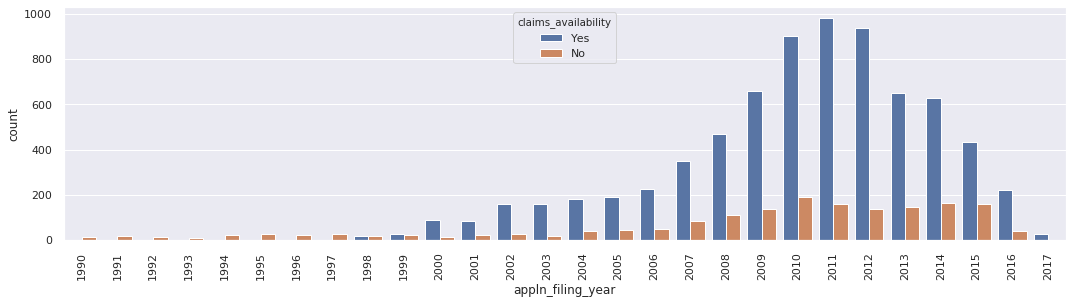

In [388]:
# data availability for EP patents
import seaborn as sns
df = table_PATSTAT[table_PATSTAT['appln_auth']=='EP']
g = sns.countplot(x='appln_filing_year', hue='claims_availability', data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

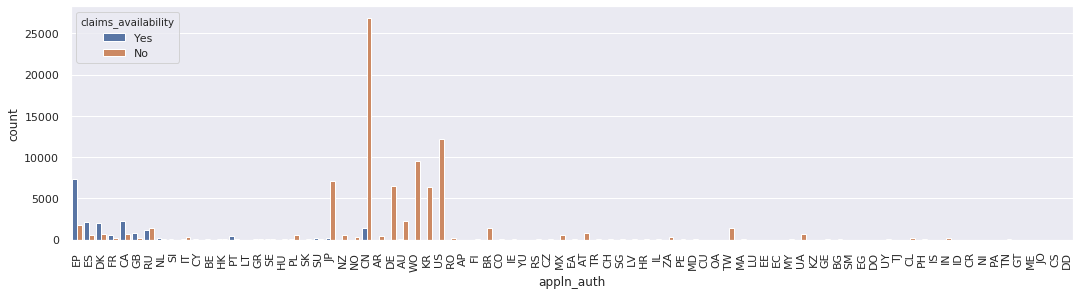

In [386]:
# data availability according to patent authority
g = sns.countplot(x='appln_auth', hue='claims_availability', data=table_PATSTAT)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [389]:
index = table_PATSTAT['nb_citing_docdb_fam'].unique().tolist()
index.sort()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 107,
 109,
 111,
 112,
 113,
 114,
 115,
 117,
 121,
 122,
 124,
 126,
 127,
 128,
 131,
 133,
 134,
 136,
 137,
 142,
 147,
 148,
 149,
 153,
 155,
 160,
 168,
 172,
 178,
 188,
 190,
 195,
 211,
 213,
 219,
 312,
 403]

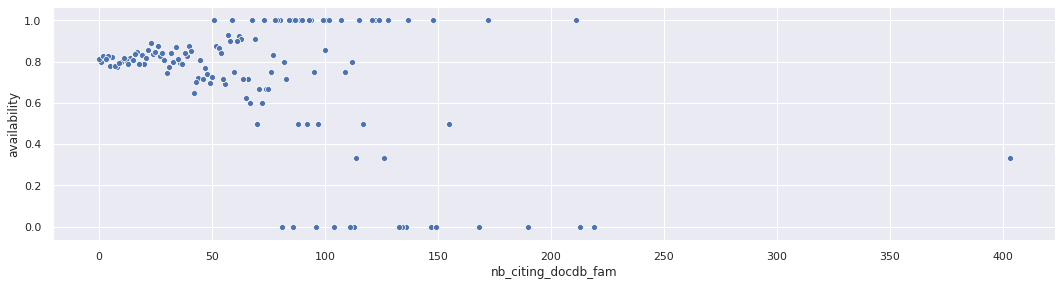

In [403]:
d = []

EP_data = table_PATSTAT[table_PATSTAT['appln_auth']=='EP']
index = EP_data['nb_citing_docdb_fam'].unique().tolist()

for i in index:
    df = EP_data[EP_data['nb_citing_docdb_fam']==i]
    y = len(df[df['claims_availability']=='Yes'])
    n = len(df[df['claims_availability']=='No'])
    availability = y/(y+n)
    
    d.append(
        {
            'nb_citing_docdb_fam': i,
            'availability': availability
        })
    

df = pd.DataFrame(d)

g = sns.scatterplot(x='nb_citing_docdb_fam', y='availability', data=df)

In [ ]:
# plot an estimation of the availability of the claims of European patents 
# according to the number of citations 

In [ ]:
g = sns.regplot(x='nb_citing_docdb_fam', y='claims_availability', data=table_PATSTAT)
g.set_xticklabels(g.get_xticklabels(), rotation=90);